> Igor Sorochan DSU-31

## Pros and Cons of Ensemble Learning Techniques in Machine Learning

| Technique        | Pros           | Cons  |Elementary models | Scikit-learn Models | Other Popular Libraries & Models |
| :--- | :---  | :---  | :---  | :---  | :---  |
|parallel models|
| **Stacking**    <br><br> strong overall model with less bias  | Can improve accuracy by combining diverse models<br>**Can handle complex and high-dimensional data** | **Can be computationally expensive**<br>Requires careful tuning of hyperparameters to avoid overfitting | Up to 5 base heterogeneous **weak** learners models (LR, KNN, SVM, DT) fit in parallel and<br> **final meta model**| StackingClassifier, StackingRegressor | mlxtend.ensemble.StackingCVClassifier, vecstack.StackingTransformer |
| **Bagging**  **b**ootstrap **agg**regat**ing**  <br><br> reduce variance  | Can improve accuracy and reduce overfitting by averaging multiple models<br>**Can handle noisy data** | **Can be limited by the diversity of the base models**<br>May not work well with highly imbalanced datasets | Typically 10-100 homogeneous **weak** learners fit in <br> parallel  and <br>final **averaging or voting** <br><br> base models with low bias but high variance| BaggingClassifier, BaggingRegressor | sklearn.ensemble.ExtraTreesClassifier, sklearn.ensemble.VotingClassifier |
| **Random Forests** <br> combines the ideas of bootstrap and **random** subspaces    | **Can handle high-dimensional data and nonlinear relationships**<br>Can handle missing data and outliers<br>Can reduce variance and overfitting | Can be limited by the diversity of the base models<br>May not work well with highly imbalanced datasets | Typically 100-500 **deep** trees and <br>final **averaging or voting**| RandomForestClassifier, RandomForestRegressor | sklearn.ensemble.ExtraTreesClassifier, sklearn.ensemble.GradientBoostingClassifier |
|sequential models|
| **Boosting**   <br><br> sequential   <br><br> strong overall model with less bias      | Can improve accuracy and reduce bias<br>**Can handle complex and high-dimensional data**<br>**Can handle imbalanced data** | **Can be computationally expensive**<br>May be sensitive to noisy data<br>Can be prone to overfitting | Typically 50-1000 homogeneous **weak** learners with sequential fixing previous model errors <br><br>weak learners with low variance but high bias| AdaBoostClassifier, AdaBoostRegressor | xgboost.XGBClassifier, lightgbm.LGBMClassifier |
| **Gradient Boosting** <br><br> | **Can handle complex and high-dimensional data**<br>**Can handle imbalanced data**<br>Can reduce bias and variance<br>**Can be faster than regular boosting** | **Can be computationally expensive**<br>Requires careful tuning of hyperparameters to avoid overfitting | Typically 100-500 **weighted sequential weak models**  | GradientBoostingClassifier, GradientBoostingRegressor | xgboost.XGBClassifier, catboost.CatBoostClassifier |

[Ensemble methods: bagging, boosting and stacking](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from math import sqrt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Prepare
### Loading data

In [3]:
df = pd.read_csv('/Users/velo1/SynologyDrive/GIT_syno/data/heart_disease.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Basic cleaning

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum().any()

False

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Process
### Variables distribution

In [7]:
# col_cat = df.columns[df.dtypes == 'object'].to_list()
# num_cols = [col for col in df.columns if df[col].dtypes == 'object']

cat_col = df.drop(['HeartDisease'], axis=1).select_dtypes(include=['object']).columns # categorical columns
num_col = df.drop('HeartDisease', axis=1).select_dtypes(include=['number']).columns   # numerical columns

df[cat_col] = df[cat_col].fillna('nan')     # fill categorical columns with 'nan' 
df[num_col] = df[num_col].fillna(999)       # fill numerical columns with 999  (in this case, 999 is a good choice because there are no 999 values in the dataset)

cat_col, num_col

(Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object'),
 Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object'))

### Variables distribution

In [8]:
fig = px.histogram(df, x='HeartDisease', color='HeartDisease', title='Heart Disease (target) distribution', width=500, height=400, text_auto=True)
fig.update_layout(barmode='group')
fig.update_xaxes(title_text='Heart Disease', tickmode='linear', tick0=0, dtick=1)

There is no significant class imbalance in the distribution of the target variable.

In [9]:
fig = make_subplots(rows=1, cols=3, column_widths=[0.2, 0.5, 0.3], subplot_titles=("", ""))
fig.layout.title.text = "Numeric variables distribution"
fig.add_trace(go.Box(y=df['Age'], notched=True, showlegend = False, name='Age'), row=1, col=2)
fig.add_trace(go.Box(y=df['RestingBP'], notched=True, showlegend = False, name = "RestingBP")           , row=1, col=2)
fig.add_trace(go.Box(y=df['Cholesterol'], notched=True, showlegend = False, name='Cholesterol')         , row=1, col=1)
fig.add_trace(go.Box(y=df['MaxHR'], notched=True, showlegend = False, name='MaxHR')                     , row=1, col=2)
fig.add_trace(go.Box(y=df['Oldpeak'], notched=True, showlegend = False, name='Oldpeak')                 , row=1, col=3)
fig.add_trace(go.Box(y=df['FastingBS'], notched=True, showlegend = False, name='FastingBS')             , row=1, col=3)
fig.add_trace(go.Box(y=df['RestingECG'], notched=True, showlegend = False, name='RestingECG')           , row=1, col=1)

fig.show()

There are outliers in some numeric variables.  
(Moreover, the number of outliers depends on target variable value.)

In [10]:
fig = px.histogram(df[cat_col], x= cat_col, title= 'Categorical variables Distribution', width= 1000, height= 600, text_auto=True)
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.12, xanchor="right", x=1))
fig.update_layout(barmode='stack')
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')
fig.show()

We see classes imbalance in some categorical variables.  
We might use SMOTE(Synthetic Minority Oversampling Technique) to balance the classes.


In [11]:
df = pd.get_dummies(df, columns=cat_col, drop_first=True)
df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,1,0,0,1,1,0,0,1,0
914,68,144,193,1,141,3.4,1,1,0,0,0,1,0,0,1,0
915,57,130,131,0,115,1.2,1,1,0,0,0,1,0,1,1,0
916,57,130,236,0,174,0.0,1,0,1,0,0,0,0,0,1,0


In [12]:
# !pip install imbalanced-learn
# # check version number
# import imblearn
# print(imblearn.__version__)

## Analisys

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('HeartDisease', axis=1), df['HeartDisease'], test_size=0.2, random_state=42)

In [14]:
results = {}

### Decision Tree

In [15]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
rep1 = classification_report(y_test, pred, digits= 4, output_dict= False, target_names= ['no disease', 'disease'])
print(rep1)
acc, rec, prec, f1, roc = accuracy_score(y_test, pred), recall_score(y_test, pred), precision_score(y_test, pred), f1_score(y_test, pred), roc_auc_score(y_test, pred)
results['Decision Tree Classifier'] = [acc, rec, prec, f1, roc]

print('Decision Tree Classifier')
print(f'Accuracy: {acc:.4f}, Recall: {rec:.4f}, Precision: {prec:.4f}, F1: {f1:.4f}, ROC: {roc:.4f}')

              precision    recall  f1-score   support

  no disease     0.7848    0.8052    0.7949        77
     disease     0.8571    0.8411    0.8491       107

    accuracy                         0.8261       184
   macro avg     0.8210    0.8232    0.8220       184
weighted avg     0.8269    0.8261    0.8264       184

Decision Tree Classifier
Accuracy: 0.8261, Recall: 0.8411, Precision: 0.8571, F1: 0.8491, ROC: 0.8232


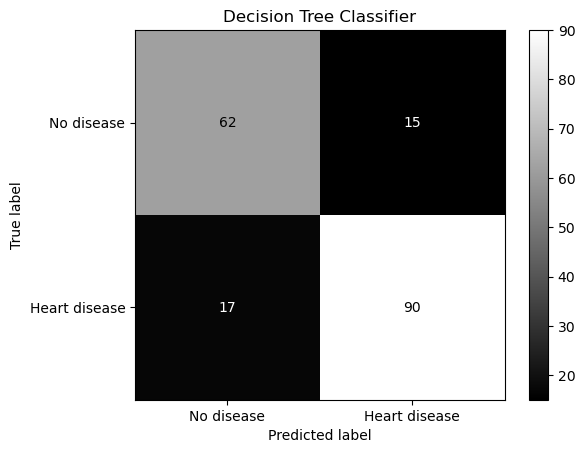

In [16]:
cm_dt=confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['No disease','Heart disease'])
disp.plot(cmap=plt.cm.gist_yarg_r)
plt.title('Decision Tree Classifier')
plt.show()

### Random Forest

In [17]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
rep2 = classification_report(y_test, pred, digits= 4, output_dict= False, target_names= ['no disease', 'disease'])
print(rep2)

acc, rec, prec, f1, roc = accuracy_score(y_test, pred), recall_score(y_test, pred), precision_score(y_test, pred), f1_score(y_test, pred), roc_auc_score(y_test, pred)
results['Random Forest Classifier'] = [acc, rec, prec, f1, roc]

print('Random Forest Classifier')
print(f'Accuracy: {acc:.4f}, Recall: {rec:.4f}, Precision: {prec:.4f}, F1: {f1:.4f}, ROC: {roc:.4f}')

              precision    recall  f1-score   support

  no disease     0.8462    0.8571    0.8516        77
     disease     0.8962    0.8879    0.8920       107

    accuracy                         0.8750       184
   macro avg     0.8712    0.8725    0.8718       184
weighted avg     0.8753    0.8750    0.8751       184

Random Forest Classifier
Accuracy: 0.8750, Recall: 0.8879, Precision: 0.8962, F1: 0.8920, ROC: 0.8725


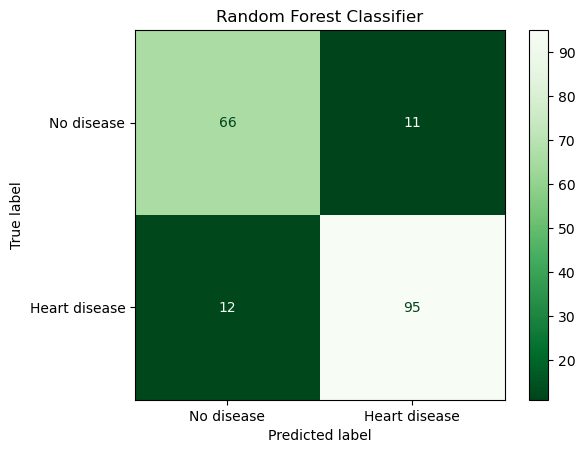

In [18]:
cm_rf=confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No disease','Heart disease'])
disp.plot(cmap=plt.cm.Greens_r)
disp.ax_.set_title("Random Forest Classifier")
plt.show()

In [19]:
temp = pd.DataFrame(results, index=['acc', 'rec', 'prec', 'f1', 'roc' ]).T.sort_values(by='roc', ascending=False)
temp.style.background_gradient( cmap='Blues')

,acc,rec,prec,f1,roc
Random Forest Classifier,0.875000,0.887850,0.896226,0.892019,0.872497
Decision Tree Classifier,0.826087,0.841121,0.857143,0.849057,0.823158


In [20]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Accuracy', 'Recall', 'Precision', 'F1', 'ROC']),
                               cells=dict(values=[list(results.keys()), temp['acc'], temp['rec'], temp['prec'], temp['f1'], temp['roc']])
                                )])

fig.show()

#### Feature importance

 The feature importance metric in Random Forest Classifier is calculated as the average reduction in Gini index across all the decision trees in the forest that use a particular feature.  
 The most commonly used metric for feature importance in Decision Tree Classifier is the mean decrease impurity (MDI), which is similar to the Gini importance used in Random Forest Classifier.


| Metric | Description | Calculation | Normalization |
|--------|-------------|-------------|---------------|
| Gini Importance | Measures the total reduction in impurity of the nodes in the decision trees that are built using each feature. | Average reduction in Gini index across all decision trees in the forest that use the feature. | The sum of importance values for all features is equal to one. |
| Mean Decrease Impurity (MDI) | Measures the total reduction in impurity or entropy over all the nodes in the tree that use a particular feature for splitting. | The sum of the decrease in impurity or entropy at each node where the feature is used for splitting. | The sum of importance values for all features is equal to one. |

Note that the actual formula for calculating the Gini importance and MDI may differ slightly depending on the specific implementation or library used. The normalization of the importance values ensures that they are comparable across features and can be used to rank features by their importance in the model.

In [21]:
fig = px.bar(dt_clf.feature_importances_, x=X_train.columns, y=dt_clf.feature_importances_, color = dt_clf.feature_importances_,
             title='DTC. Feature Importance', width=1000, height=600, color_continuous_scale= ['LightBlue','Blue','DarkBlue'])
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='Mean Decrease in Impurity')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.update_coloraxes(showscale=False) # hide the color scale
fig.show()

In [22]:
fig = px.bar(rf_clf.feature_importances_, x=X_train.columns, y=rf_clf.feature_importances_, color = rf_clf.feature_importances_,
             title='RFC. Feature Importance', width=1000, height=600, color_continuous_scale= ['Lightsalmon','darkorange','red'])
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='Gini Importance')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.update_coloraxes(showscale=False) # hide the color scale
fig.show()

In [23]:
fig = go.Figure(data=[go.Bar(y=dt_clf.feature_importances_, text=np.round(dt_clf.feature_importances_,4),
                             x= X_train.columns, textposition='auto', marker_color='lightblue', name='Decision Tree Classifier' ),
                             go.Bar(y=rf_clf.feature_importances_, text=np.round(rf_clf.feature_importances_,4),
                                    x= X_train.columns, textposition='auto', marker_color='darkorange', name='Random Forest Classifier' )
                                    ], layout=go.Layout( height=800))
fig.update_layout(barmode='group', title='Feature Importance', xaxis_title='Features', yaxis_title='Mean Decrease in Impurity(DTC) / Gini Importance(RFC)')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.update_layout(legend=dict(orientation="h", yanchor="top", y=0.98, xanchor="right", x=0.99))
fig.show()

We can notice that DecisionTreeClassifier and RandomForestClassifier apply different importance levels.  
This is especially noticeable in the example of `ST_Slope_Flat` feature.  
The first one is based on the Gini impurity and the second one is based on the mean decrease in impurity (MDI).  
The MDI is the average decrease in the criterion (Gini impurity) brought by a feature over all the trees in the forest.  
The Gini importance is the average decrease in the criterion brought by a feature over all the trees in the forest.  



### Bagging (Bootstrap Aggregating)

In [24]:
bagg_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bagg_clf.fit(X_train, y_train)
pred = bagg_clf.predict(X_test)
rep3 = classification_report(y_test, pred, digits= 4, output_dict= False, target_names= ['no disease', 'disease'])
print(rep3)

acc, rec, prec, f1, roc = accuracy_score(y_test, pred), recall_score(y_test, pred), precision_score(y_test, pred), f1_score(y_test, pred), roc_auc_score(y_test, pred)
results['Bagging Classifier'] = [acc, rec, prec, f1, roc]


              precision    recall  f1-score   support

  no disease     0.8250    0.8571    0.8408        77
     disease     0.8942    0.8692    0.8815       107

    accuracy                         0.8641       184
   macro avg     0.8596    0.8632    0.8611       184
weighted avg     0.8653    0.8641    0.8645       184



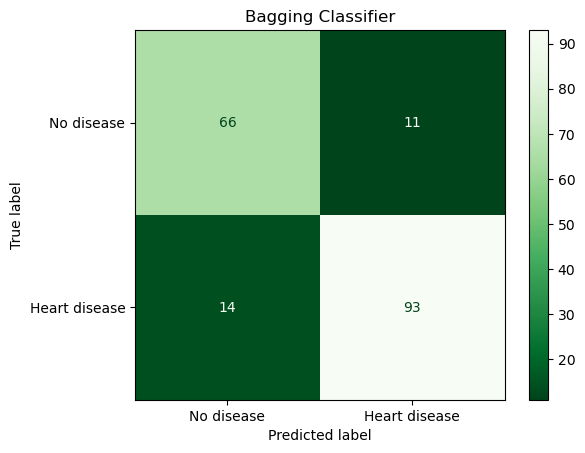

In [25]:
cm_bagg=confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bagg, display_labels=['No disease','Heart disease'])
disp.plot(cmap=plt.cm.Greens_r)
disp.ax_.set_title("Bagging Classifier")
plt.show()

### Stacking ensemble

In [26]:
st_clf = StackingClassifier([('dt', DecisionTreeClassifier(random_state=42)), ('rf', RandomForestClassifier(random_state=42)), ('svm', LinearSVC())], final_estimator=LogisticRegression(max_iter= 3000), cv=5, n_jobs=-1, passthrough=True)
st_clf.fit(X_train, y_train)
pred = st_clf.predict(X_test)
rep4 = classification_report(y_test, pred, digits= 4, output_dict= False, target_names= ['no disease', 'disease'])
print(rep4)

acc, rec, prec, f1, roc = accuracy_score(y_test, pred), recall_score(y_test, pred), precision_score(y_test, pred), f1_score(y_test, pred), roc_auc_score(y_test, pred)
results['Stacking Classifier'] = [acc, rec, prec, f1, roc]


/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

  no disease     0.8442    0.8442    0.8442        77
     disease     0.8879    0.8879    0.8879       107

    accuracy                         0.8696       184
   macro avg     0.8660    0.8660    0.8660       184
weighted avg     0.8696    0.8696    0.8696       184



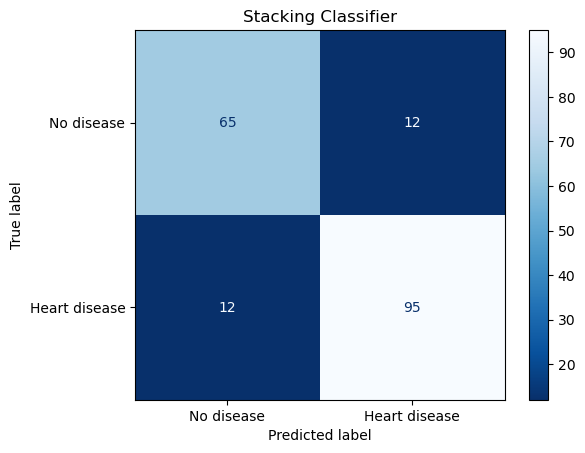

In [27]:
cm_st=confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_st, display_labels=['No disease','Heart disease'])
disp.plot(cmap=plt.cm.Blues_r)
disp.ax_.set_title("Stacking Classifier")
plt.show()

In [28]:
st_clf.estimators_

[DecisionTreeClassifier(random_state=42),
 RandomForestClassifier(random_state=42),
 LinearSVC()]

In [29]:
temp = pd.DataFrame(results, index=['acc', 'rec', 'prec', 'f1', 'roc' ]).T.sort_values(by='roc', ascending=False)
temp.style.background_gradient( cmap='Blues').format('{:.4f}')

,acc,rec,prec,f1,roc
Random Forest Classifier,0.8750,0.8879,0.8962,0.8920,0.8725
Stacking Classifier,0.8696,0.8879,0.8879,0.8879,0.8660
Bagging Classifier,0.8641,0.8692,0.8942,0.8815,0.8632
Decision Tree Classifier,0.8261,0.8411,0.8571,0.8491,0.8232


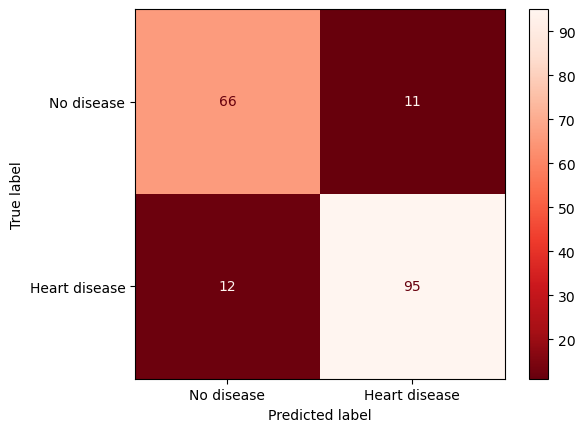

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No disease','Heart disease'])
disp.plot(cmap=plt.cm.Reds_r)
plt.show()

We still have 14 FN predictions, which is not good in case of the heart disease detection.  
We can try to improve the model by tuning the hyperparameters.

RFC is a robust and reliable algorithm that often outperforms Stacking and Bagging in terms of accuracy, speed, and generalization ability mainly due to:  
* reduced overfitting and variance
* Better Feature Selection: RFC randomly selects a subset of features for each tree, which can help to identify the most important features for the prediction task
* Higher Accuracy (lower bias)
* Faster Training